# Lab 4: Recurrent models

This lab represents the practice with embeddings (word vectors, in this case) and recurrent neural models in NLP. The first part focuses on embeddings as input to a recurrent model, and the second part focuses on contextual embeddings derived from transformer models, applying them to the task of word sense disambiguation following the approach from the original paper by [Peters et al. (2018)](https://aclanthology.org/N18-1202.pdf)

# Rules
* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.

* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header.

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells.
* Don't change the names of provided functions and variables or arguments of the functions.
* Leave the output of your code in the output cells.
* **Don't output unnecessary info** (e.g., printing variables for debugging purposes) or **add extra code cells** (e.g., for mounting your google drive). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.
* Don't forget to fill in the contribution information.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>


* Samuele Milanese, Matteo Di Bari, Riccardo Campanella
* we all contributed equally

# General instructions

Before diving into the exercises, keep in mind that the variables defined previously can be reused in the subsequent cells. So there is no need to redefine the same variable in multiple sections, e.g., it is sufficient to read the file in a variable once and later reuse the value of the variable, instead of re-reading the file.   

If your code is too long and using several code cells instead of a single code cell. Rethink how to organize data in variables that you can easily access required info. Reading about [list comprehension](https://realpython.com/list-comprehension-python/#leverage-list-comprehensions) can be useful.

Your code will often be evaluated based on its behaviour. So, during the grading some code cells are executed. If code runtime is too long than expected, this will hinder grading.

<font color="red">**The cases similar to the above-mentioned ones, will be subject to penalty points.**</font>

<font color="red">**Pay attention to test units**</font> that are either provided as assert cases or as comments. Test units help you by giving you a hint about a correct answer. Note that **passing test units doesn't guarantee the full points** for an execise because test units are incomplete and the code might fail on other test units.

# Part 1: POS tagging with LSTM

In the first part of lab 4, we will play with training a recurrent model for part of speech tagging. We start with implementing the evaluation and training procedures for LSTM-based tagger. Initially we will work on the toy data so that you understand the procedures. Later we use the Brown corpus with Universal POS tags. We will train a tagger on the data and analyse the training dynamics. Then we will use pre-trained word embeddings to initialize an LSTM. We will experiment with training taggers with and without pre-trained word vectors.

## Setup

In [1]:
import random, math
import nltk
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm

# if any cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
# torch-specific code
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
torchtext.disable_torchtext_deprecation_warning()

In [3]:
print(f"NLTK version: {nltk.__version__}")
print(f"torch version: {torch.__version__}")

NLTK version: 3.8.1
torch version: 2.3.0+cu121


In [4]:
# download several data incorporated in NLTK
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('semcor')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Some auxiliary functions that will be reused throughout the notebook

def plot_numbers(num_listm, xlabel="Epochs", ylabel="Loss", label=None):
    """ Visualizes a list of numbers as a line plot
    """
    plt.plot(np.arange(len(num_listm)), num_listm, 'o-', markersize=2, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if label: plt.legend()

# Let's plot the loss values and see how training on more epochs decreases the loss value
def plot_results(res, parts=("train", "valid"), metrics=("loss", "acc"), title=None):
    """ Shorthand for contrasting loss and accuracy numbers obtained on different datasets
    """
    for m in metrics:
        for p in parts:
            plot_numbers(res[p][m], label=f"{p} {m}", ylabel=m)
        if title: plt.title(title)
        plt.show()

def train_validation_split(sequence, train_ratio, valid_ratio, seed=0, seperate_tags=False):
    """ returns two non-overlapping subpart of the input sequence.
        The sizes of the parts satisfy the size ration constraint.
        If seperate_tags is on, this means the input has format of [(w1,pos1), (w2,pos2)]
        and it will be converted to [(w1,w2), (pos1,pos2)]
    """
    assert train_ratio + valid_ratio <= 1
    population = list(sequence)
    n = len(population)
    train_num, valid_num = math.floor(n * train_ratio), math.floor(n * valid_ratio)
    random.seed(seed)
    data = random.sample(population, train_num + valid_num)
    if seperate_tags:
        data = [ list(zip(*sent)) for sent in data ]
    return data[:train_num], data[train_num:]

## LSTM tagger

Read the [pytorch tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) on sequence tagging with LSTM. It is very important that you practice how to read and understand the tutorials on web. Not all tutorials are written in a clear way, and understanding the overlooked parts requires practice and effort.
Fortunately, the aforementioned tutorial is very well written. Though it uses many new operations related to tensors (=a multi-dimensional matrix containing elements of a single data type).

Pytorch is well documented and almost any function, method, or class can be looked up [here](https://pytorch.org/docs/stable/index.html), in the top-left corner. For example, `torch.randn` is defined [here](https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn). Note that keywords in the code of the tutorial are hyperlinks with links to the corresponding documentation.

The code below is copied from the tutorial page as we will reuse certain variables and functions. We only renamed the data variable name to indicate that it is toy data.

In [6]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


toy_training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in toy_training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


The code below is also copied from the tutorial but it incorporates two additions:

1.   Fixing the torch's random generator seeds: see `nn_seed` and `em_seed`. These seeds control the initialization of `self.word_embeddings` from [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) and `self.lstm` from [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). In the first case, the `vocab_size` number of `embedding_dim`-dimensional tensors are generated, while in the second case the LSTM network is initialized with random weights (note that `self.hidden2tag` is also randomized weights denoting `V` matrix, from J&M chapter 9, that is used to obtain output from the hidden layer for each time step). We make the LSTM initialization based on the seed to maintain replicability of the same results.

2.   Making the class flexible to allow initialization from pre-trained word embeddings. `embedding` input can be a tuple that specifies the dimensions of the embedding layer or a ready tensor that records pre-trained word embeddings.

In [7]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, hidden_dim, tagset_size, nn_seed=0, em_seed=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        if isinstance(embedding, torch.Tensor):
            self.word_embeddings = nn.Embedding.from_pretrained(embedding)
            embedding_dim = self.word_embeddings.weight.size(1)
        else:
            torch.manual_seed(em_seed)
            vocab_size, embedding_dim = embedding
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        torch.manual_seed(nn_seed)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Ex1.1a [7pt] Evaluation

The training (i.e. last) code in the [tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging) contains lines of code that we will reuse several times. That's why we are going to make specific functions out of them. The first function we will make takes a model and data (and other stuff) and returns predictions and metrics wrapped in a dictionary. read the function definition carefully for more details.

In [8]:
def evaluate_tagger(model, data, w2i=None, t2i=None, get_tags=False, get_scores=False):
    """ model - an NN model, in particular an LSTMTagger object
        data - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices, when w2i is not specified this means that
            tokens are already mapped to indices in data and no mapping is needed. This option
            will be handy when evaluating a tagger several times on a data during the training.
        t2i - a dict mapping POS tags to indices. When t2i is not specified this means that
            pos tags are already mapped to indices in data, and also when returning tags
            as an output, they won't be mapped to human readable tags, but instead returned
            as indices.
        get_tags - whether return predicted tags (i.e., most probable tag per token)
        get_scores - whether to return actual tag scores for each token
    return:
        a dictionary with keys 'loss', 'acc', 'scores', 'tags'.
        Note that the loss value is averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
        The keys are present in the dictionary for certain values according to the input.
        For example, if get_tags=False, there shouldn't be 'tags' key in the dictionary.
        As an example, see the reference output below.
    """
    ### YOUR CODE HERE ###
    loss_function = nn.NLLLoss()

    losses = []
    score_list = []
    tag_list = []

    correct_predictions = 0
    total_tags = 0

    with torch.no_grad():
        for sentence, tags in data:
            # Preparing input and target tags
            sentence_in = prepare_sequence(sentence, w2i) if w2i else sentence
            targets = prepare_sequence(tags, t2i) if t2i else tags

            score = model(sentence_in)
            losses.append(loss_function(score, targets))
            score_list.append(score)

            # Finding the predictions (most probable tag per token)
            probabilities = F.softmax(score, dim=1)
            predicted_tags = torch.argmax(probabilities, dim=1)

            # Updating the number of correctly predicted tags
            correct_predictions += (predicted_tags == targets).sum().item()
            total_tags += len(targets)

            # I translate the predicted tags indices in human readable tags (if t2i is given)
            if t2i:
              predicted_tags_list = predicted_tags.tolist()
              readable_tags = []
              for _ in predicted_tags_list:
                readable_tags.append(list(t2i.keys())[_])
              predicted_tags = readable_tags

            tag_list.append(predicted_tags)

    # Loss value is averaged across sentences
    loss_avg = np.mean(np.array(losses), dtype = float)

    # Computing the accuracy
    acc = correct_predictions / total_tags

    ret = {'loss': loss_avg, 'acc' : acc}
    if get_tags:
      ret['tags'] = tag_list
    if get_scores:
      ret['scores'] = score_list

    return ret

In [9]:
# TEST Ex1.1
# deterministically initialize LSTM tagger and predict the tags for the data
toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# evaluate tagger
pred = evaluate_tagger(toy_tagger, toy_training_data, w2i=word_to_ix, t2i=tag_to_ix, get_tags=True, get_scores=True)
print(pred)

print("Tokens, gold tags, and predicetd most probable tag per token")
for (sent, tags1), tags2 in zip(toy_training_data, pred['tags']):
    for seq in (sent, tags1, tags2):
        print(''.join([ f"{el:^8}" for el in seq ]))

{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple  
  DET      NN      V      DET      NN   
   NN      NN     DET      NN      NN   
Everybody  read    that    book  
   NN      V      DET      NN   
   NN     DET     DET      NN   


Reference output:

```
{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple
  DET      NN      V      DET      NN
   NN      NN     DET      NN      NN
Everybody  read    that    book
   NN      V      DET      NN
   NN     DET     DET      NN
```

## Q1.1b [3pt] Explain predictions



1.   *Given the above predictions from the tagger, is there any rationale for why the tagger predicts NN often?*
2.   *What is the predicted probability distribution over the tags for "that" in the data*? In case your tagger's output is different from the reference output, make clear which output your answer is based on.



<font color="red">█████ YOUR ANSWER HERE █████</font>

1 - The tagger predicts NN often because it is the most common tag in the toy training data.

2 - These are the scores for "that": [-0.9478, -1.0155, -1.3856]. This is the probability distribution computed using them: [0.3876, 0.3622, 0.2502]

## Ex1.2: [8pt] Training

We need to write a function that trains a model on the data. This function later will be reused for training the tagger on different training sets. Again, reuse the code from the tutorial page to complete the body of the function. *Keep the learning rate same*. During training the training data is isually shuffled, but here, for simplicity, *don't shuffle the data*, keep it as it is.
Note that the function has to return the list of loss and accuracy values that is one item longer than the number of epochs.
Don't forget to **reuse** `evaluate_tagger` function.
Read the function definition for more details.

**Hints**: the function presupposes training and evaluating a model on the same data several times. Make sure that you convert the data into tensors once and not for every epoch.
Feel free to define sub-functions that will be reused for train and valid parts. This will make the code less redundant.
The tqdm module gives a nice way to report the progress of training.

In [10]:
def train_tagger(model, train, w2i, t2i,
                 valid=None, epoch_num=10, verbose=False):
    """ model - an NN model, in particular an LSTMTagger object
        train - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices
        t2i - a dict mapping POS tags to indices
        valid - optional validation data structurally identical to train.
            When the validation data is provided, the output also records results about it.
        epoch_num - the number of times to train the model on the train data
        verbose - a flag that makes the function print various useful info. For example,
            it can be used to turn on/off the tqdm progress bar during the training.

        return:
            a dictionary with keys 'train' and 'valid', the existence of the latter depends
            on whether the valid arg is provided. The values of the keys are dictionaries
            with keys 'loss', 'acc', 'best_acc'. The first two have a list value of length epoch_num + 1.
            This is because it includes the loss & acc of the initial model and the final too.
            Note that the loss value should be averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
            'best_acc' keeps the max values from the 'acc' list.
            See the reference output below as an example.
    """
    ### YOUR CODE HERE ###
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    n_sentences = len(train)
    ret = {}
    ret['train'] = {'loss': [], 'acc': [], 'best_acc': None}
    if valid: ret['valid'] = {'loss': [], 'acc': [], 'best_acc': None}

    # Evaluating the initial model
    train_evaluations = evaluate_tagger(model, train, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
    ret['train']['loss'].append(train_evaluations['loss'])
    ret['train']['acc'].append(train_evaluations['acc'])
    if valid:
        val_evaluations = evaluate_tagger(model, valid, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
        ret['valid']['loss'].append(val_evaluations['loss'])
        ret['valid']['acc'].append(val_evaluations['acc'])

    # This loop goes for epoch_num + 1 times because the first iteration
    # is dedicated to the evaluation of the initial model (with no trainig)
    rng = tqdm(range(epoch_num)) if verbose else range(epoch_num)
    for epoch in rng:
        for sentence, tags in train:
            # Clearing the gradients before each
            model.zero_grad()

            # Preparing the inputs
            sentence_in = prepare_sequence(sentence, w2i)
            targets = prepare_sequence(tags, t2i)

            # Running the forward pass
            tag_scores = model(sentence_in)

            # Updating the parameters
            loss = loss_function(tag_scores, targets)
            loss.backward()
            optimizer.step()

        # Evaluating with train and validation set and updating the returned dictionary
        train_evaluations = evaluate_tagger(model, train, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
        ret['train']['loss'].append(train_evaluations['loss'])
        ret['train']['acc'].append(train_evaluations['acc'])
        if valid:
            val_evaluations = evaluate_tagger(model, valid, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
            ret['valid']['loss'].append(val_evaluations['loss'])
            ret['valid']['acc'].append(val_evaluations['acc'])

    # Computing the best accuracy for train and validation set
    ret['train']['best_acc'] = np.max(ret['train']['acc'])
    if valid: ret['valid']['best_acc'] = np.max(ret['valid']['acc'])

    return ret

In [11]:
# TEST Ex1.2-1
# defining a toy validation set
toy_validation_data = [
    ("The dog read that book".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody ate the apple".split(), ["NN", "V", "DET", "NN"])
]
# initialize the model
trained_toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# train and retrieve the loss values per epoch
res = train_tagger(trained_toy_tagger, toy_training_data, word_to_ix, tag_to_ix, valid=toy_validation_data, epoch_num=200)
print(f"results: {res}")

results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.04059898853302, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.0299551486968994, 1.0281798839569092, 1.0263945758342743, 1.0245959162712097, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153113901615143, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260922431946, 1.0032211244106293, 1.0010755360126495, 0.9988870024681091, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821901917457581, 0.9795820713043213, 0.9769113957881927, 0.974175900220871

Reference output
```
results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.0281798839569092, 1.0263945162296295, 1.0245959758758545, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821900725364685, 0.9795820713043213, 0.9769113957881927, 0.9741758704185486, 0.971373051404953, 0.968500405550003, 0.9655555188655853, 0.9625357389450073, 0.9594384133815765, 0.9562608897686005, 0.9530004262924194, 0.9496542811393738, 0.9462195336818695, 0.9426933825016022, 0.9390727579593658, 0.9353549182415009, 0.9315365552902222, 0.9276146292686462, 0.9235861897468567, 0.9194479286670685, 0.9151966571807861, 0.9108293950557709, 0.9063427448272705, 0.9017335474491119, 0.8969985246658325, 0.8921345770359039, 0.8871385455131531, 0.8820073008537292, 0.8767377138137817, 0.8713269233703613, 0.8657719492912292, 0.8600700199604034, 0.8542185723781586, 0.8482151329517365, 0.8420574069023132, 0.8357434272766113, 0.8292712569236755, 0.8226395547389984, 0.8158469200134277, 0.8088927268981934, 0.8017762303352356, 0.7944974899291992, 0.7870568335056305, 0.779455155134201, 0.7716937363147736, 0.7637743949890137, 0.7556994557380676, 0.747471958398819, 0.7390953898429871, 0.7305739521980286, 0.7219121754169464, 0.7131155133247375, 0.7041897773742676, 0.6951413750648499, 0.685977429151535, 0.6767054200172424, 0.6673334836959839, 0.657869964838028, 0.64832404255867, 0.6387049555778503, 0.6290224492549896, 0.6192863881587982, 0.6095071136951447, 0.5996948778629303, 0.5898602306842804, 0.5800137519836426, 0.5701659321784973, 0.5603272318840027, 0.5505081117153168, 0.5407186597585678, 0.5309689044952393, 0.5212685018777847, 0.5116268247365952, 0.5020530223846436, 0.49255549907684326, 0.4831426292657852, 0.47382208704948425, 0.4646011292934418, 0.455486536026001, 0.44648461043834686, 0.43760116398334503, 0.42884135246276855, 0.420210063457489, 0.4117113947868347, 0.4033491313457489, 0.3951266258955002, 0.38704653084278107, 0.379111185669899, 0.37132251262664795, 0.36368197202682495, 0.35619062185287476, 0.34884922206401825, 0.3416580855846405, 0.3346172273159027, 0.32772640883922577, 0.3209850490093231, 0.3143923729658127, 0.30794721841812134, 0.3016485273838043, 0.2954946607351303, 0.2894841134548187, 0.28361500799655914, 0.27788545936346054, 0.27229342609643936, 0.2668367102742195, 0.26151304692029953, 0.25632014125585556, 0.2512555569410324, 0.24631685763597488, 0.24150147289037704, 0.23680689930915833, 0.23223048448562622, 0.22776974737644196, 0.22342193126678467, 0.2191845253109932, 0.21505482494831085, 0.21103034913539886, 0.20710836350917816, 0.20328643918037415, 0.19956187903881073, 0.1959322690963745, 0.19239506870508194, 0.18894780427217484, 0.18558815866708755, 0.1823136806488037, 0.17912207543849945, 0.17601102590560913, 0.17297829687595367, 0.17002175748348236, 0.1671391949057579, 0.16432850062847137, 0.16158772259950638, 0.15891478210687637, 0.15630778670310974, 0.15376483649015427, 0.1512840986251831, 0.1488637775182724, 0.14650212973356247, 0.14419741183519363, 0.14194803684949875, 0.13975241407752037, 0.13760895282030106, 0.13551612943410873, 0.13347259163856506, 0.13147679716348648, 0.12952743843197823, 0.12762318551540375, 0.1257627233862877, 0.12394478917121887, 0.12216819450259209, 0.12043173983693123, 0.11873431876301765, 0.11707473546266556, 0.11545206606388092, 0.11386516317725182, 0.11231311783194542], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}, 'valid': {'loss': [1.0846959352493286, 1.0808380246162415, 1.0773123502731323, 1.074073314666748, 1.0710812211036682, 1.0683015584945679, 1.0657045245170593, 1.0632638335227966, 1.0609570741653442, 1.0587645769119263, 1.0566694736480713, 1.0546568036079407, 1.0527135729789734, 1.050828456878662, 1.048991858959198, 1.0471948385238647, 1.0454300045967102, 1.0436905026435852, 1.0419704914093018, 1.04026460647583, 1.0385679006576538, 1.0368764400482178, 1.0351861119270325, 1.0334933400154114, 1.031795084476471, 1.0300881266593933, 1.0283698439598083, 1.0266374945640564, 1.0248886346817017, 1.0231209993362427, 1.0213320851325989, 1.0195199251174927, 1.0176822543144226, 1.015817105770111, 1.0139222741127014, 1.0119959115982056, 1.010036051273346, 1.008040428161621, 1.0060072541236877, 1.0039344429969788, 1.0018200278282166, 0.9996618628501892, 0.9974577724933624, 0.9952059388160706, 0.992904007434845, 0.9905498921871185, 0.9881412386894226, 0.9856758415699005, 0.9831514060497284, 0.9805654585361481, 0.9779156148433685, 0.975199431180954, 0.9724143147468567, 0.9695577323436737, 0.9666268825531006, 0.9636191427707672, 0.9605317711830139, 0.9573618173599243, 0.9541065096855164, 0.950762927532196, 0.9473278522491455, 0.9437984228134155, 0.940171480178833, 0.936443954706192, 0.9326125979423523, 0.9286741614341736, 0.9246255159378052, 0.9204634130001068, 0.9161844551563263, 0.9117855131626129, 0.9072633981704712, 0.9026147425174713, 0.8978364765644073, 0.8929254114627838, 0.8878785669803619, 0.8826929926872253, 0.8773658275604248, 0.8718942999839783, 0.8662759959697723, 0.8605084121227264, 0.854589432477951, 0.8485172688961029, 0.8422901332378387, 0.8359066545963287, 0.8293657600879669, 0.8226668834686279, 0.8158095479011536, 0.8087940514087677, 0.8016207814216614, 0.7942907512187958, 0.7868053317070007, 0.7791665494441986, 0.7713768780231476, 0.7634392380714417, 0.755357176065445, 0.7471347451210022, 0.7387764751911163, 0.7302875816822052, 0.7216735482215881, 0.7129406034946442, 0.7040953636169434, 0.6951448917388916, 0.6860966384410858, 0.6769585013389587, 0.667738676071167, 0.658445805311203, 0.6490887403488159, 0.6396763920783997, 0.6302180886268616, 0.6207231283187866, 0.6112009882926941, 0.6016610860824585, 0.5921128392219543, 0.5825656354427338, 0.5730288028717041, 0.5635112524032593, 0.5540220439434052, 0.5445697605609894, 0.5351628661155701, 0.5258093178272247, 0.5165170133113861, 0.5072932541370392, 0.49814508855342865, 0.4890791177749634, 0.48010173439979553, 0.4712185859680176, 0.46243521571159363, 0.45375658571720123, 0.44518721103668213, 0.43673138320446014, 0.42839284241199493, 0.4201749265193939, 0.41208066046237946, 0.4041126221418381, 0.3962731957435608, 0.38856421411037445, 0.38098737597465515, 0.3735438734292984, 0.3662347346544266, 0.35906076431274414, 0.3520224094390869, 0.3451198488473892, 0.3383530527353287, 0.3317219018936157, 0.3252258598804474, 0.3188643902540207, 0.3126366436481476, 0.30654168128967285, 0.30057843029499054, 0.2947455793619156, 0.28904177248477936, 0.28346555680036545, 0.27801529318094254, 0.27268923819065094, 0.26748569309711456, 0.26240262389183044, 0.2574382796883583, 0.25259044021368027, 0.24785716831684113, 0.24323634058237076, 0.23872575163841248, 0.23432327806949615, 0.23002667725086212, 0.2258337214589119, 0.2217421904206276, 0.21774984151124954, 0.21385441720485687, 0.21005363762378693, 0.20634539425373077, 0.20272734761238098, 0.1991974264383316, 0.1957533359527588, 0.1923929899930954, 0.1891142502427101, 0.18591507524251938, 0.18279334902763367, 0.17974704504013062, 0.1767742782831192, 0.17387297004461288, 0.17104127258062363, 0.16827736794948578, 0.16557937115430832, 0.16294549405574799, 0.1603739634156227, 0.157863087952137, 0.15541130304336548, 0.1530168540775776, 0.15067820623517036, 0.1483938843011856, 0.14616229385137558, 0.14398206025362015, 0.1418517380952835, 0.13976992666721344, 0.1377352774143219, 0.1357465460896492, 0.1338024064898491, 0.13190167769789696, 0.13004306703805923, 0.12822554260492325, 0.1264479085803032, 0.12470909580588341], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}}

```

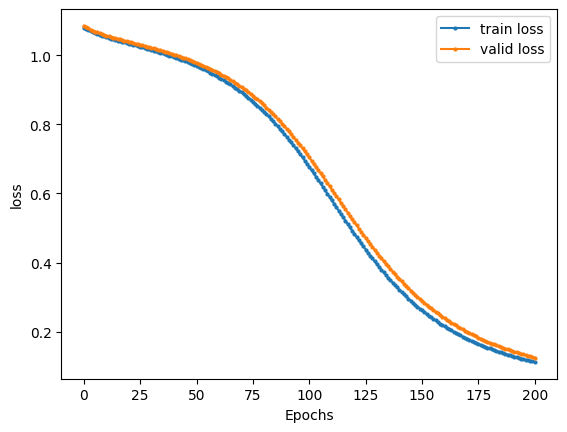

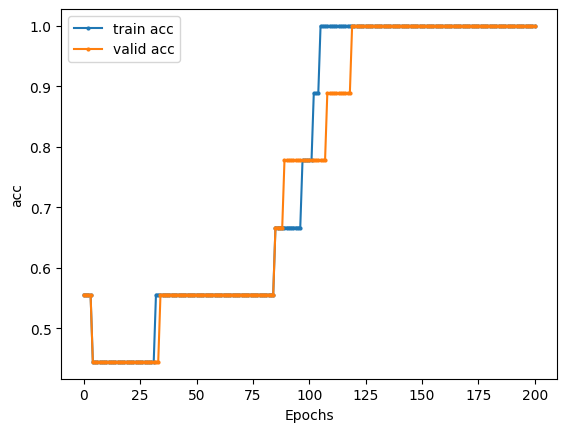

In [12]:
# TEST Ex1.2-2
# DON'T DELETE THE OUTPUT
plot_results(res)

## Brown corpus

In this exercise we use the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) for English annotated with the [Universal POS (UPOS) tags](https://www.nltk.org/book/ch05.html#a-universal-part-of-speech-tagset). We can access the data from an NLTK's corpus list. Note that the UPOS tagset contains much fewer tags than the PennTreebank POS tags. This makes UPOS tagging relatively easy.

You are provided with a function `train_validation_split` which extracts two subsets from the given corpus. The size of the subsets can be specified in terms of the ratio to the entire corpus size.

In [13]:
# defining the corpus view (of type ConcatenatedCorpusView), which can be iterated
BROWN_UPOS = list(nltk.corpus.brown.tagged_sents(tagset='universal'))
# Peeking inside the data
print(BROWN_UPOS[:2])

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [14]:
# This is how to get training and validation parts of different sizes from the data
# we use seperate_tags=True to format the extracted parts according to the format of the toy datasets,
# i.e., putting tokens and their POS tags in separate lists
sample_train_data, sample_valid_data = train_validation_split(BROWN_UPOS, 0.1, 0.1, seperate_tags=True)
print(f"Training data ({len(sample_train_data)}) and validation data ({len(sample_valid_data)})")

Training data (5734) and validation data (5734)


## Ex1.3a [3pt] Train UPOS tagger

Write a code that initializes a new LSTM tagger with the **embedding dimensionality 32** and **hidden layer dimensionality 16**.
We are opting for the low-dimensional representations to keep the training time reasonable on CPUs.
Note that you will also need to create the mappings of words and tags to indices based on the data.
To be deterministic in creating the mappings, *sort tags and words* with `sorted` and then map sorted elements to indices. For example, this should map the token `!` and the tag `.` to 0s.

Train the tagger on `sample_train_data` with **50 epochs** and evaluate on `sample_valid_data` using your `train_tagger` function. Save the training results in `upos_res` which will be plotted by the test cell.

In [15]:
%%time
### YOUR CODE HERE ###
# save results in upos_res
# should take 25min on colab's cpu

words = set()
pos = set()
for sent in BROWN_UPOS:
    for word in sent:
        words.add(word[0])
        pos.add(word[1])
word_mapping = {}
tag_mapping = {}
for word in sorted(words):
    word_mapping[word] = len(word_mapping)
for tag in sorted(pos):
    tag_mapping[tag] = len(tag_mapping)

model = LSTMTagger((len(word_mapping), 32), 16, len(tag_mapping))
upos_res = train_tagger(model, sample_train_data, w2i=word_mapping, t2i=tag_mapping, valid=sample_valid_data, epoch_num=50, verbose=True)

100%|██████████| 50/50 [17:26<00:00, 20.93s/it]

CPU times: user 17min 8s, sys: 4.48 s, total: 17min 12s
Wall time: 17min 37s


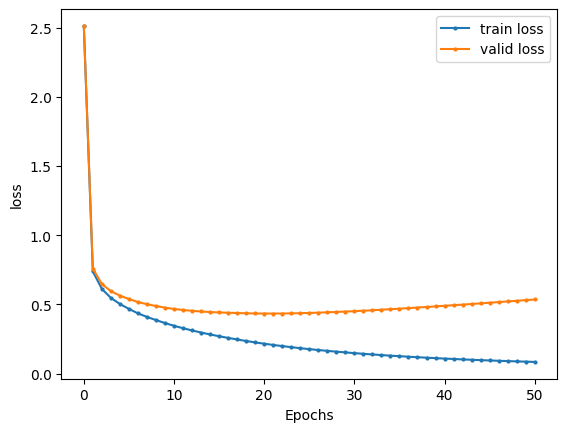

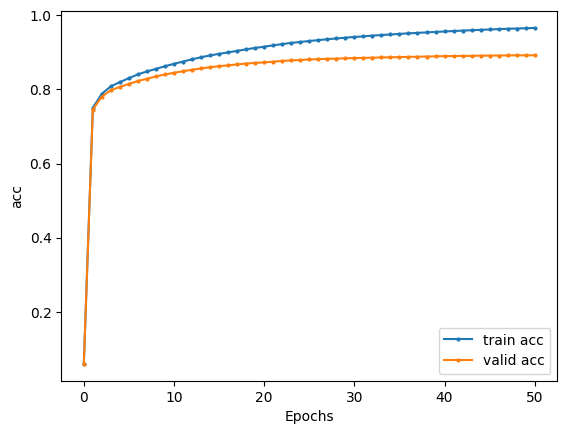

In [16]:
# TEST Ex1.3
# DON'T DELETE THE OUTPUT
plot_results(upos_res)

## Q1.3b [2pt] Best model

Based on the training dynamics of the accuracy scores on the training and validation parts, after which epoch (if any) is recommended to stop training and why?

<font color="red">█████ YOUR ANSWER HERE █████</font>

If we analyse the dynamics of the accuracy scores, we would recommed to stop training around epoch 20 because the validation accuracy does not get much better after it. At the same time, the validation loss seems to be getting higher whereas training loss gets lower. This usually indicates overfitting to the training data. It is better for us to consider the validation metrics instead of the training meetrics when comparing the performance of models because it better represents their ability to generalize.

## GloVe embeddings

In this section we are downloading the [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained static word embeddings. We will reuse it to initialize the embedding layer of an LSTM, as opposed to the random initialization we have been using so far.

In [17]:
# downloading from the Dutch server (should be a bit faster than the original source)
GLOVE_FILE = "glove.6B.100d.txt"
!wget -nv https://naturallogic.pro/_files_/download/mNLP/{GLOVE_FILE}.bz2
!bzip2 -dk glove.6B.100d.txt.bz2

2024-06-11 16:43:08 URL:https://naturallogic.pro/_files_/download/mNLP/glove.6B.100d.txt.bz2 [107798047/107798047] -> "glove.6B.100d.txt.bz2" [1]


In [18]:
# Loading vectors from the file
from torchtext.vocab import Vectors
glove = Vectors(GLOVE_FILE, cache=".")
print(glove.vectors.shape)

100%|█████████▉| 399999/400000 [00:22<00:00, 18001.28it/s]


torch.Size([400000, 100])


GloVe comes with its own word-to-index mapping: `stoi` (strings to indices). You can access each word's vector as shown below.

In [19]:
word1 = "human" #@param {type:"string"}
word2 = "" #@param {type:"string"}
if word1 and word2:
    tensor1 = glove.vectors[glove.stoi[word1]]
    tensor2 = glove.vectors[glove.stoi[word2]]
    sim = F.cosine_similarity(tensor1, tensor2, dim=0).item()
    print(f"similarity({word1}, {word2}) = {sim}")
elif word1:
    print(f"The index is {glove.stoi[word1]}")
    print(f"The vector is {glove.vectors[glove.stoi[word1]]}")

The index is 473
The vector is tensor([ 3.3864e-01,  5.9663e-01,  5.3322e-01,  3.1404e-01,  1.5321e-01,
         3.1749e-01, -4.2940e-01, -2.9150e-01, -2.1047e-03, -3.9309e-01,
        -8.5441e-01, -8.0708e-02,  1.2118e+00,  6.9316e-02,  8.0613e-03,
         8.7888e-01,  3.1908e-02,  5.8655e-01, -5.4892e-01, -7.8468e-03,
         1.7327e-01, -2.6693e-01,  4.2802e-01,  6.6123e-02,  5.1847e-01,
         7.7226e-01,  2.0608e-01, -4.5836e-01,  3.5485e-01,  7.1547e-01,
         6.0855e-01,  2.0254e-01, -4.8756e-01,  5.7974e-01,  8.6728e-02,
        -5.1852e-01, -3.7274e-01,  1.0014e+00, -2.9259e-01,  3.2290e-01,
        -9.7563e-01, -2.2288e-01, -2.3335e-01, -2.6891e-01,  1.4612e-01,
         1.2004e-01, -2.0402e-01, -9.4647e-02, -1.5402e+00, -5.9510e-02,
         1.0887e+00, -2.4998e-01, -2.5808e-01,  1.2798e+00, -1.2849e-01,
        -1.4511e+00, -2.4686e-01, -9.5046e-02,  1.7425e+00,  1.1977e-01,
        -1.9206e-01,  4.4368e-01, -1.6453e-01, -7.6663e-01,  1.1100e+00,
         4.6748e-01,

## Ex1.4a [8pt] Random vs GloVe

In this exercise we are comparing two LSTM-based UPOS taggers, one with randomly initialized embeddings while another reusing the GloVe embeddings.
To bolster the comparison, we will restrict the data only to those tagged sentences that consist of the words covered by the GloVe vectors (Note that GloVe covers 400K words). This also helps to reduce the data and make the experiments feasible for the colab's CPU.

Complete the designated code cell below so that it runs the following experiment:

1.   For each train & valid data split initialize two LSTM-based taggers, with the random and GloVe embeddings.
2.   Train each tagger with a predefined number of epochs. Obviously, you should reuse `train_tagger` function here.
3.   After the training is done, record the max/best score across the epochs on the validation part (because the validation score better represents the model's capacity than the training data). Use `best_valid_acc` to keep track of the best scores for each type of embedding initialization.

One important detail! This is an example of how to initialize an LSTM tagger with the GloVe word vectors that is expected to predict $N$ number of tags.
Remember, this was the reason why we modified the LSTMTagger class from the PyTorch tutorial.

```
LSTMTagger(glove.vectors, HIDDEN_DIM, N)
```

In [20]:
EMB_DIM = glove.vectors.size(1)
HID_DIM = 20
valid_ratio = 0.2
train_ratios = [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8]
epoch_num = 50
# keep the best accuracy on the valid part here. Keys
best_valid_acc = {'glove':[], 'random':[]}
# For better contrast, we are keeping only those sentences in the Brown corpus for which we have GloVe vectors
# and also keep only those sentences that have 3 and more tokens
GLOVE_BROWN = [ sent for sent in BROWN_UPOS if len(sent) > 2 and all([ w in glove.stoi for w, _ in sent ]) ]
print(f"New data size = {len(GLOVE_BROWN)}")

New data size = 1589


In [21]:
%%time
# It should take less than 25mins
### YOUR CODE HERE ###
word_mapping_glove = {}
tag_mapping_glove = {}
for sentence in GLOVE_BROWN:
  for word, tag in sentence:
    if word not in word_mapping_glove:
        word_mapping_glove[word] = len(word_mapping_glove)
    if tag not in tag_mapping_glove:
        tag_mapping_glove[tag] = len(tag_mapping_glove)

for train_ratio in tqdm(train_ratios):
    train_data, valid_data = train_validation_split(GLOVE_BROWN, train_ratio, valid_ratio, seperate_tags=True)

    random_model = LSTMTagger((len(word_mapping_glove), EMB_DIM), HID_DIM, len(tag_mapping_glove))
    random_res = train_tagger(random_model, train_data, w2i=word_mapping_glove, t2i=tag_mapping_glove, valid=valid_data, epoch_num=epoch_num)

    glove_model = LSTMTagger(glove.vectors, HID_DIM, len(tag_mapping_glove))
    glove_res = train_tagger(glove_model, train_data, w2i=glove.stoi, t2i=tag_mapping_glove, valid=valid_data, epoch_num=epoch_num)

    best_valid_acc['random'].append(random_res['valid']['best_acc'])
    best_valid_acc['glove'].append(glove_res['valid']['best_acc'])

100%|██████████| 7/7 [11:29<00:00, 98.56s/it] 

CPU times: user 11min 14s, sys: 3.05 s, total: 11min 17s
Wall time: 11min 29s


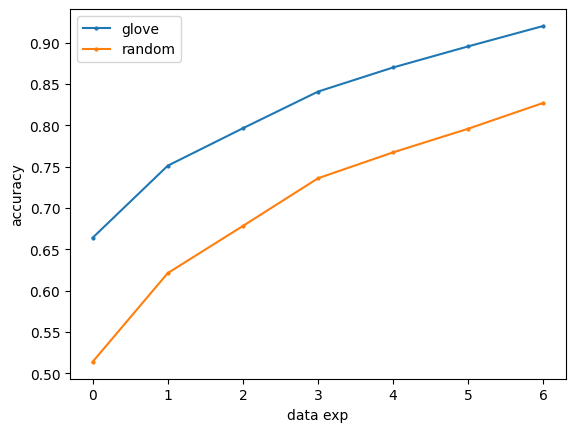

In [ ]:
# TEST 1.4
# DON'T DELETE THE OUTPUT
plot_numbers(best_valid_acc['glove'], label='glove', ylabel='accuracy', xlabel='data exp')
plot_numbers(best_valid_acc['random'], label='random', ylabel='accuracy', xlabel='data exp')

## Q1.4b [2pt] Conclusion

Based on the plots of the best accuracy scores on the validation part, how would you compare the use of randomized embeddings to the use of pre-trained embeddings?

<font color="red">█████ YOUR ANSWER HERE █████</font>

Even if the difference in accuracy gets slightly smaller if we increase the training set size, the performance of the pre-trained embeddings is always better than the randomized ones'.

# Part 2: Word sense disambiguation

In this part we will use the BERT transformer model's contextualized word embeddings to tackle the word sense disambiguation (WSD) task. The approach consists of the following:

1. Get the contextualized BERT embeddings for all tokens in a sense-annotated corpus;
2. For each sense $s$, calculate a mean vector of all the vectors of the words that are tagged with the sense $s$ in the training part of the corpus;
3. For each sense-annotated token $t$ in the test part of the corpus, assign $s$ sense to $t$ such that the vector of $s$ is the closest to the vector of $t$.
4. As a backup strategy for tokens in the test part for which no sense vector was obtained from the training part (i.e., tokens with unseen senses), use the 1st sense of the token by default.

## Setup

In [ ]:
# Course-specific package
! rm -rf assigntools
! git clone https://github.com/kovvalsky/assigntools.git
from assigntools.NLP.deep_learning import transformer_word2convec
from assigntools.M4LP.A1 import read_pickle, write_pickle

Cloning into 'assigntools'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 255 (delta 22), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (255/255), 62.92 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
import random, torch
import torch.nn.functional as F
from collections import defaultdict, Counter
from tqdm import tqdm
from tabulate import tabulate
import nltk
from more_itertools import chunked
from nltk.corpus import wordnet as wn
from nltk.corpus import semcor
from nltk.corpus.reader.wordnet import Lemma
nltk.download('semcor')
nltk.download('wordnet')

# append any imports if needed

[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## SemCor

As a sense annotated corpus, we will use SemCor, conveniently available within NLTK. <code>semcor.sents()</code> iterates over all sentences represented as lists of tokens, while <code>semcor.tagged_sents()</code> iterates over the same sentences with additional annotation including WordNet Lemma identifiers (Lemma in WordNet stands for a particular sense of a word as opposed to a synset that is a set of Lemmas).

In [ ]:
# two sample sentence from the semcor corpus
# with their corresponding sense-annotated versions
for i in [0, 27]:
    print(semcor.sents()[i])
    print(semcor.tagged_sents(tag="sem")[i])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', 'Atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
[['The'], Tree(Lemma('group.n.01.group'), [Tree('NE', ['Fulton', 'County', 'Grand', 'Jury'])]), Tree(Lemma('state.v.01.say'), ['said']), Tree(Lemma('friday.n.01.Friday'), ['Friday']), ['an'], Tree(Lemma('probe.n.01.investigation'), ['investigation']), ['of'], Tree(Lemma('atlanta.n.01.Atlanta'), ['Atlanta']), ["'s"], Tree(Lemma('late.s.03.recent'), ['recent']), Tree(Lemma('primary.n.01.primary_election'), ['primary', 'election']), Tree(Lemma('produce.v.04.produce'), ['produced']), ['``'], ['no'], Tree(Lemma('evidence.n.01.evidence'), ['evidence']), ["''"], ['that'], ['any'], Tree(Lemma('abnormality.n.04.irregularity'), ['irregularities']), Tree(Lemma('happen.v.01.take_place'), ['took', 'place']), ['.']]
['His', 'petition', 'charged', 'mental', 'cruelty

Let's prepare SemCor data for the disambiguation task. Since this is just an educational exercise and we don't aim at replicating the full results, we can use only a subset of SemCor. Take the first $N$ sentences of SemCor, pre-process the data, shuffle the sample in the data **randomly**, and finally split the data into the training and test sets.

In [ ]:
# Extract a part of the data for experiments
N = 10_000
semcor_annotated = list(semcor.tagged_sents(tag='sem')[:N])
semcor_tokenized = list(semcor.sents()[:N])
random.Random(42).shuffle(semcor_annotated)
random.Random(42).shuffle(semcor_tokenized)

## Ex2.1 [9pt] Preprocessing data

Create a function that takes as input a collection of sense-annotated sentences from SemCor and extracts the sense annotation. For each token of the sentence get either the corresponding WordNet sense or <code>None</code>.
<code>None</code> corresponds to tokens that are: (1) not annotated with a Lemma object sense (e.g. articles); (2) representing a part of a larger phrase that is annotated with a sense. The latter represents a simplification of the task.  
More info about NLTK's Lemma and Tree objects can be found here: [Lemma](https://www.nltk.org/api/nltk.corpus.reader.wordnet.html) and [Tree](https://www.nltk.org/api/nltk.tree.tree.html).

In [ ]:
def get_sns_annotations(data):
    """ data - sense tagged data from semcor
        return
            the sense annotations as a list of lists.
            The structure follows to semcor sentences and tokenization
            The elements of the list are None or a tuple of strings
            representing a synset and a lemma.
            None annotation means that a word token has no sense annotation
    """
    ### YOUR CODE HERE ###

    all_sentences = []
    for sentence in data:
        curr_sentence = []
        for tok in sentence:
            if type(tok) is nltk.tree.tree.Tree:

                if len(tok.leaves()) == 1 and tok.height() <= 2: # token must not be a part of a longer phrase
                    if type(tok.label()) is str:
                        curr_sentence.append(None)
                    else:
                        curr_sentence.append((tok.label().synset().name(), tok.label().name()))
                else:
                    curr_sentence.extend(len(tok.leaves())*[None])
            else:
                curr_sentence.extend(len(tok)*[None])
        all_sentences.append(curr_sentence)
    return all_sentences


In [ ]:
# TEST Ex2.1
semcor_senses = get_sns_annotations(semcor_annotated)

print("sample sentence:", semcor_tokenized[0])
print("sample annotation:", semcor_senses[0])

print("sample sentence:", semcor_tokenized[13])
print("sample annotation:", semcor_senses[13])

print("Total number of senses in the data =", len([ t for s in semcor_senses for t in s if t ]))

# test that for all sentences token number and annotation length are the same
for i, (senses, tokenized) in enumerate(zip(semcor_senses, semcor_tokenized, strict=True)):
    assert len(senses) == len(tokenized), \
        f"mismatch for {i}th sentence\n{senses}\n{tokenized}"

sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
sample sentence: ['It', 'just', 'did', "n't", 'occur', 'to', 'Trig', 'that', 'anything', 'serious', 'would', 'happen', 'to', 'him', '.']
sample annotation: [None, ('merely.r.01', 'just'), None, None, ('occur.v.02', 'occur'), None, None, None, None, ('dangerous.s.02', 'serious'), None, ('happen.v.02', 'happen'), None, None, None]
Total number of senses in the data = 84296


Reference output:
```
sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
sample sentence: ['It', 'just', 'did', "n't", 'occur', 'to', 'Trig', 'that', 'anything', 'serious', 'would', 'happen', 'to', 'him', '.']
sample annotation: [None, ('merely.r.01', 'just'), None, None, ('occur.v.02', 'occur'), None, None, None, None, ('dangerous.s.02', 'serious'), None, ('happen.v.02', 'happen'), None, None, None]
Total number of senses in the data = 84296
```

In [ ]:
# Run the following to get a reference data for comparison
# If your data differs from the reference, use the reference data in the subsequent parts
# !rm -f semcor_senses.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/semcor_senses.pkl
# semcor_senses = read_pickle("semcor_senses.pkl")

In [ ]:
# create training and test sets
train_N = 9_000
semcor_X = {'train':semcor_tokenized[:train_N], 'test':semcor_tokenized[train_N:]}
semcor_Y = {'train':semcor_senses[:train_N], 'test':semcor_senses[train_N:]}

## BERT's contextualized vectors

After we have the training and test sets prepared with their gold sense annotations, it is time to get sense vectors for those senses that are occurring in the training set. Note that **contextualized vectors are crucial for the task** as a word (e.g., "book", "plant", "figure") can have different senses in different contexts.

We will use BERT transformer model to get contextualized word vectors for the words in the training and test sets. We will use the implementation of BERT in pytorch from the [transformers library](https://huggingface.co/docs/transformers/index).

Getting word vectors from BERT is not trivial as it uses a different type of tokenization than the traditional one. For example, the base-uncased version of BERT expects `Jupyter` tokenized as `ju`, `##py`, `##ter` while `Notebook` as `notebook` (note the lower casing of tokens due to the uncased version of BERT). To distinguish these two versions of tokenization and tokens, we will use `tokens` for BERT tokens and words for traditional tokenization. For example, the SemCor sentences use traditional tokenization.

If you want to learn more about BERT, [this](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) represents a gentle intro to BERT's wordpiece-based tokenizatio and contextualized word vectors.

In [ ]:
# if this cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# install transformer library
# !pip install transformers

In [ ]:
import transformers
from transformers import BertModel, AutoTokenizer
print(transformers.__version__) # 4.41.0

4.41.2


In [ ]:
# Load tokenizer (vocabulary)
MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# As usual, tokens are mapped to indices
print("The size of the token vocabulary", len(tokenizer.vocab))
for tok in ("dog", "##tion"):
    print(f"'{tok}' has index {tokenizer.vocab[tok]}")

for i in (3899, 3508):
    print(f"Reverse mapping: {i} --> {tokenizer.convert_ids_to_tokens(i)}")

The size of the token vocabulary 30522
'dog' has index 3899
'##tion' has index 3508
Reverse mapping: 3899 --> dog
Reverse mapping: 3508 --> ##tion


In [ ]:
example_input = "Transformers in Jupyter Notebook"
tok_result = tokenizer(example_input)
print("Output of a tokenizer: ", tok_result)
print("Tokens as word pieces: ", tokenizer.convert_ids_to_tokens(tok_result.input_ids))

Output of a tokenizer:  {'input_ids': [101, 19081, 1999, 18414, 7685, 3334, 14960, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens as word pieces:  ['[CLS]', 'transformers', 'in', 'ju', '##py', '##ter', 'notebook', '[SEP]']


`[CLS]` and `[SEP]` are special tokens use by BERT. `[CLS]` gets a vector that models the meaning of the entire input text sequence while `[SEP]` indicates sequence delimiters. Note that one of the tasks BERT was pre-trained on was guessing the next sentence, hence it was trained on sequence modeling, where elements of the sequence are sentences. Note that the output of `tokenizer([S1, S2])` and `tokenizer(S1, S2)` differ as in the first case the input is interpreted as a batch of two independent texts while in the second it is a sequence of texts.

The output of the tokenizer provides a sufficient input for BERT to process the input and assign contextualized embeddings.

In [ ]:
# Load pre-trained model (weights)
bert = BertModel.from_pretrained(MODEL_NAME)

#print parameters
bert.parameters

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
)>

In [ ]:
# let bert output hidden states
bert.config.output_hidden_states = True
# bert expects tensors as an input
tok_result = tokenizer(example_input, return_tensors='pt')
bert_output = bert(**tok_result)
print("Dimension of the last (12th) hidden states (batch size X token number X vector dim): ", bert_output.hidden_states[-1].shape)

Dimension of the last (12th) hidden states (batch size X token number X vector dim):  torch.Size([1, 8, 768])


Due to non-trivial correspondence between BERT tokens and words, we provide you with a ready function that takes a batch/list of word-tokenized sentences and processes them with the BERT model. In the end, it returns contextualized word vectors for each input word. The vector of the words that consist of several tokens is obtained by collating token vectors (e.g., taking the mean by default). The function allows to indicate from which layer the vectors should be extracted. For more details you can read the function definition [here](https://github.com/kovvalsky/assigntools/blob/main/NLP/deep_learning.py).

In [ ]:
# Batches with GPU accelerates the process ~30 times when used T4 GPU of colab compared to CPU
# Obviously for this toy example, efficiency doesn't matter
# this identifies whether GPU is present
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("we are using", device)

sample_batch = [ "Transformers in Jupyter Notebook".split(), "Transformers visited the earth".split() ]
sample_output = transformer_word2convec(bert, tokenizer, sample_batch, device=device, collate_tok_vec=torch.mean, layer=-1)

# illustrating the output
for sent in sample_output:
    for w in sent:
        print(f"'{w['word']}' tokenized as {w['tokens']} with tensor (first 3 components) {w['pt'][:3]}")
    print()

# Comparing vectors of two occurrences of "Transformers"
tvec1, tvec2 = sample_output[0][0]['pt'], sample_output[1][0]['pt']
print(f"{tvec1[:5]}... != {tvec2[:5]}...")
print(f"vectors cosine similarity = {F.cosine_similarity(tvec1, tvec2, dim=0)}")

we are using cuda
'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.2651, -0.0888, -0.1850])
'in' tokenized as ['in'] with tensor (first 3 components) tensor([ 0.8255,  0.1081, -0.4694])
'Jupyter' tokenized as ['ju', '##py', '##ter'] with tensor (first 3 components) tensor([-0.1719, -0.5191,  0.3761])
'Notebook' tokenized as ['notebook'] with tensor (first 3 components) tensor([-0.2273, -0.4334,  0.7509])

'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.4967,  0.0918, -0.0243])
'visited' tokenized as ['visited'] with tensor (first 3 components) tensor([ 1.2033, -0.1839, -0.5399])
'the' tokenized as ['the'] with tensor (first 3 components) tensor([-0.8393,  0.1038,  0.2743])
'earth' tokenized as ['earth'] with tensor (first 3 components) tensor([-0.8355, -0.2884, -0.1953])

tensor([-0.2651, -0.0888, -0.1850,  0.4485,  0.1538])... != tensor([-0.4967,  0.0918, -0.0243,  0.1993, -0.2419])...
vectors cosine simi

## Ex2.2 [10pt] Sense vectors

Process the training set with BERT using `transformer_word2convec` with default parameters. After getting word vectors, iterate over all train sentences, and for each sense, collect the word vectors. Note that words without sense annotations will be ignored in this process.

Since senses in the same WordNet synset are considered equivalent, we will be using synsets as sense labels. Prepare a dictionary with synset `(synset_str)` as a key and a single tensor as a value. The tensor should be a mean of all the word vectors collected for the sense (this is a default collating method used by `transformer_word2convec`).

This process is a time-consuming part of this assignment. It is recommended to use Colab's GPU: max 5min of T4 GPU will suffice to process all sentences with BERT. While processing the sentences, use batches of size 64 (Hint: `chunked` from `more_itertools` can do batching for you). Note that batches make a big difference with GPU. For the purposes of developing and debugging your solution, you may start by using a sample of 100 sentences, but then switch to the full training set.

In [ ]:
import more_itertools

# you can reuse global vars bert and tokenizer
def get_sense2vec(data_X, data_Y, batch_size=64, device=device, collate=torch.mean):
    """ data_X and data_Y are a list of tokenized semcor sentences with their corresponding sense annotations.
        The last two arguments are the same as in transformer_word2convec
        Returns 2 dictionaries:
            Sense2VecList - { synset_str -> list of tensors  }
            Sense2AvgVec - { synset_str -> a mean tensor  }
    """
    ### YOUR CODE HERE ###
    sense2veclist = defaultdict(list)
    sense2vec = {}
    chunk_size = batch_size
    # iterate over all train sentence use batches of size 64 (first try with 100 sentences)
    for X_chunk, Y_chunk in zip(more_itertools.chunked(data_X, chunk_size), more_itertools.chunked(data_Y, chunk_size)): # chunck is a subset of train
        chunk_ouput = transformer_word2convec(bert, tokenizer, X_chunk, device=device, collate_tok_vec=torch.mean, layer=-1)
        for i, sentence in enumerate(X_chunk):
            # for each sense collect the word vectors
            for j, sense in enumerate(Y_chunk[i]):
                if sense is not None:
                    synset = sense[0]
                    sense2veclist[synset].append(chunk_ouput[i][j]['pt']) # bert's embedding for the synset
    # averaging vectors for each synset
    for synset in sense2veclist:
        sense2vec[synset] = torch.mean(torch.stack(sense2veclist[synset]), dim=0)

    return sense2vec, sense2veclist

In [ ]:
# ~50min with CPU, less than 2min with T4 GPU
BATCH_SIZE = 64

Sense2AvgVec, Sense2VecList = get_sense2vec(semcor_X['train'], semcor_Y['train'], batch_size=BATCH_SIZE)

In [ ]:
# If you want to use reference vectors for next exercises, run the following:
# !rm -f Sense2AvgVec.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/Sense2AvgVec.pkl
# Sense2AvgVec = read_pickle("Sense2AvgVec.pkl")

In [ ]:
# TEST Ex2.2
for sns in [ 'mature.v.01', 'promptly.r.01', 'state.v.01', 'be.v.01']:
    assert isinstance(Sense2VecList[sns], list)
    assert isinstance(Sense2VecList[sns][0], torch.Tensor)
    assert isinstance(Sense2AvgVec[sns], torch.Tensor)
    print(f"{sns} sense has {len(Sense2VecList[sns])} vectors with the mean vector = {Sense2AvgVec[sns][:8]} ...")

mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...


Reference output
```
mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...
```

## Ex2.3 [12pt] WSD testing

Now we are going to evaluate the sense embeddings on the test set. Write a function that takes a list of tokenized sentences and a mask that indicates which words are supposed to get senses. The function should return the sense predictions aligned with the sentences. When predicting a sense for a word token, use the strategy outlined above, with 1st WordNet sense as a fallback. Here is the strategy in more detail:

- Use the sense vectors that were calculated based on the training set;
- For each sense-annotated word token $t$ (e.g. the verb `run`) in the test set, predict the synset $s$ (e.g., `'run.x.xx'`) such that the vector of $s$ is the closest to the contextualized vector of $t$ based on the cosine distance metric. Also make sure that the predicted sense is applicable to a word token using [`wn.synsets()`](https://www.nltk.org/howto/wordnet.html).
- There will be word tokens $t$ in the test set for which there won't be a sense vector collected from the training set, i.e., unseen senses. For such word tokens, us a backup strategy and predict the 1st sense of the word from WordNet, which is the most common sense of the word. This can be done using a built-in function from NLTK (e.g. <code>wn.lemmas('run')[0]</code>). For more info about NLTK's WordNet API, check [this](https://www.nltk.org/howto/wordnet.html).

Note that the info that a word token has a gold sense unseen in the training set (provided by the mask argument), is not realistic info as it presupposes knowledge about gold annotations.

Below you are provided with the sense masking that indicates whether a word token gets a sense and whether its sense was seen in the training set.

In [ ]:
# masking of annotations: None - has NO sense annotation; True - has sense annotation and the sense
# was seen in the training set; False - has sense annotation but the sense was NOT seen in the training set
test_sense_mask = [ [ i if i is None else ( True if i[0] in Sense2AvgVec else False ) for i in s ] \
                        for s in semcor_Y['test'] ]

def wsd_accuracy(predictions, reference):
    """ Calculates accuracy with respect to the word tokens that get sense annotations.
    """
    true_and_false = [ p == r[0] for preds, refs in zip(predictions, reference, strict=True) \
                       for (p, r) in zip(preds, refs, strict=True) if r is not None ]
    return sum(true_and_false)/len(true_and_false)

In [ ]:
def predict_senses(sense2vec, sentences, sense_mask, fallback=False,
                   batch_size=BATCH_SIZE, bert=bert, tokenizer=tokenizer, device=device):
    """ sense2vec - a dictioanry from synset strings to torch tensor vectors
        sentences - a list of sentences each being a list of word tokens
        sense_mask - it is aligned with tokens of sentences and tells if a token gets sense
                    and what type sense, seen or unseen in the training set.
        fallback - if True it uses first sense as the option for tokens with unseen senses.
        batch_size - the number of sentences is a batch
        bert, tokenizer - bert model and a tokenizer compatible with it
        device - a cpu or a gpu/cuda device that will be used by bert and tensor computations
        return predictions
            a list of list of predictions (None or a synset as a string) where the structure
            is aligned with the sentences
    """
    ### YOUR CODE HERE ###
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert.to(device)
    predictions=[]

    # processing in batch
    for start in range(0, len(sentences), batch_size):
        end = min(start + batch_size, len(sentences))
        batch_sentences = sentences[start:end]
        batch_mask = sense_mask[start:end]
        batch_output = transformer_word2convec(bert, tokenizer, batch_sentences,
                                         device=device, collate_tok_vec=torch.mean,
                                         layer=-1)
        # processing each tuples of sentence, mask, bert's output
        for sen, mask, out in zip(batch_sentences, batch_mask, batch_output):
            curr_pred = []
            for word, is_masked, word_vec in zip(sen, mask, out):

                if is_masked: # token is in training set
                    # filtering out unseen synsets
                    seen_synsets = [synset for synset in wn.synsets(word) if synset.name() in sense2vec.keys()]
                    if not seen_synsets: # if there are no senses for the token
                      curr_pred.append(None)
                      continue
                    # computing cosine similarity between the current token vector and the possible synsets' vectors
                    synset_mat = torch.stack([sense2vec.get(synset.name()) for synset in seen_synsets]).to(device)
                    sense_idx = torch.argmax(F.cosine_similarity(word_vec['pt'].to(device), synset_mat, dim=1))
                    curr_pred.append(seen_synsets[sense_idx].name())

                elif is_masked is False and fallback: # fallback strategy
                    word = word.lower()
                    synsets = wn.synsets(word)
                    first_synset = synsets[0].name() if synsets else None
                    curr_pred.append(first_synset)

                else: # if is_masked is none or no fallback strategy
                  curr_pred.append(None)

            predictions.append(curr_pred)

    return predictions


In [ ]:
# TEST Ex2.3
# DON'T DELETE THE OUTPUT
# expected runtime less than a minute
predictions = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask)
predictions_fb = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask, fallback=True)

print("\nAccuracy of BERT      =", wsd_accuracy(predictions, semcor_Y['test']))
print("Accuracy of BERT + WN =", wsd_accuracy(predictions_fb, semcor_Y['test']))


Accuracy of BERT      = 0.6516674840608141
Accuracy of BERT + WN = 0.6969102501226091


Reference output (where `X<Y`):

```
Accuracy of BERT      = 0.6X...
Accuracy of BERT + WN = 0.6Y...
```

## Further experiments

Congratulations! You have reached the end of lab 4.

If you want an additional challenge, you can carry out further experiments on WSD task. Note that in the experiments we used the vectors from the last layer of BERT, but several research papers have shown that the vectors from different layers also encode useful information.

1.   You can test whether the vectors from other layers perform better than the last layer vectors.
2.   Word (and sense vectors) can be defined in terms of the combinations of the vectors from several layers of BERT. You can verify whether concatenating vectors from different layers (e.g., a concatenation of vectors from the last two layers) performs better than the vectors from the single layers.


# Acknowledgment

The initial assignment by Denis Paperno included the contrast of pretrained and random word embeddings on POS tagging (using the extended Penn Treebank POS tags) and replication of the WSD experiment for ELMo. The assignment was built around the allennlp library.

Since 2022-23 course, the assignment was substantially changed by Lasha Abzianidze. allennlp was replaced with pytorch and transformers library. ELMo was replaced with BERT and Penn Treebank POS tagging with Universal POS tagging. The first part now teaches students how to build a neural network tagger instead of using out-of-the-box tagger. These changes also drastically decreased GPU/CPU processing time.